# Prototype 02
#### Tasks
##### Done

- Why are we not using softmax in the last layer of the agent? [o]
- Check timos epsilon decay strategy [✓]
- Introduce verbosity levels [✓]
- Split the dataset presented to each client [✓]
- Check the format of training data [✓]
- Add softmax to the last layer [✓] 
- Make function to save the most important details about an experiment in a README.md file and save it with the models and the graphics [✓]
- Improve the log experiment function [✓]
- Check why the learning curve shows twice as many epochs as actually existent [✓]
- Add saving functionality to the plotting functions [✓]
- write the experiment summary directly into the md file [✓]
- Add the global training time and the round training time [✓]
- Add a name function to the agent and make the global agent return the correct name [✓]
- Check why there is twice as many episodes in the graph as there should be [✓]
- Align the markdown table to the left [✓]
- Save the full training time [✓]
- Save the rount training time on each client [✓]
- Add the execution date to the experiment report [✓]
- Use the pipe table [✓]
- How many threads can my macbook pro run in parallel => 6 (12 with Hyperthreadding) [✓]
- Check if the experiment directory already exists and if yest delete it and make space for the new files [✓]
- Check different types of tables [✓]
- Remove the verbosity flag from the server train functions [✓]
- Change the blue in the graphics to a darker blue and the red to a more poppy color. [✓]
- Make a subindex possible for the experiment [✓]
- Check if the replay memoery init can be moved internally (client_01.init_replay_memory(MIN_REPLAY_SIZE)) [✓]
- Check that the test data is independant from the train data [✓]

##### Open

- Validate the copying of the parameters works properly
- How often do i have to initialze the replay memory?
- Make sure that the weights of the DQN are not being reset by the training
- If you really want to make this work online then the right aggregation strategy is key. Maybe ensemble models would be good.
- Check different federated aggregation strategies for class distinct problems
- Parallelize the training
- Move the training to the GPU.
- Make the threadding more efficient
- Add f1 score and confusion matrix
- Check the weighting strategy that Timo used
- Ipmlemtne Multiclass Imbalance Degree (MID) Metric
- Print a graph with overall attack detection accuracy (How many got mitigated and how many did not get mitigated)
- Check which loss we are using (purpose of binary cross entropy loss)
- Add confusion matrices
- Check RMS Prop
- Check why there is 4 actions (possible outputs) of the DQN while we only use 3 MTDs. Does zero mean no MTD?
- Move each class to its own file
- Better split the training data to clients
- What is the purpose of share memory function?
- Check if the DQN is always randomly re-initialized
- plot the training data splits
- Check why the parallelized training is not faster?
- Maybe we should use the model with the best test performance
- Check why there is 4 output actions
- Check the format of the training data
- Make graphs that cover the global test accuracy over all rounds for all clients (including the global agent)
- Make sure that the online & target network is randomyl re-initialized again

## Training on Google Collab 

In [1]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

ModuleNotFoundError: No module named 'google'

In [ ]:
# Go to base directory
%cd /content/drive/MyDrive/University/Master-Thesis/Code

## Training on Local Machine

In [5]:
import os

original_working_directory_path = os.getcwd()
print("The original working directory is {0}".format(os.getcwd()))

def to_original_working_directory():
    os.chdir(original_working_directory_path)
    print(f"Changed to original working directory {original_working_directory_path}")

The original working directory is /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code/prototypes/prototype_02


In [6]:
def to_root_working_directory():
    root_working_directory_path = os.path.join(original_working_directory_path, "../..")
    os.chdir(root_working_directory_path)
    print(f"Changed to root working directory {os.getcwd()}")

In [7]:
to_root_working_directory()

Changed to root working directory /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code


In [8]:
# Validate that python 3.10 is used
!python --version

Python 3.10.9


In [9]:
def seed_random():
    random.seed(42)
    torch.random.manual_seed(42)
    np.random.seed(42)

## --- Dependencies ---

In [10]:
# Standard Dependencies
import sys
import os
import numpy as np
from time import time

In [43]:
# Global Dependencies
from src.custom_types import Behavior, MTDTechnique
from src.data_provider import DataProvider
from src.evaluation_utils import plot_learning, seed_random, get_pretrained_agent, evaluate_agent, evaluate_agent_on_afterstates
from src.autoencoder_utils import evaluate_ae_on_no_mtd_behavior, get_pretrained_ae, pretrain_ae_model

## --- Hyperparameters ---

In [3]:
# Hyperparams

GAMMA = 0.1 #0.99 # discount factor for future rewards
BATCH_SIZE = 100
N_EPISODES = 10000

NR_ROUNDS = 10
NR_EPISODES_PER_ROUND = 1000

BUFFER_SIZE = 500
MIN_REPLAY_SIZE = 100
# Epsilon determining Exploration Exploitation Trade Off
EPSILON_START = 1.0
EPSILON_DEC = 1e-4 # 0.001
EPSILON_END = 0.01

TARGET_UPDATE_FREQ = 100
LEARNING_RATE = 1e-4
LOG_FREQ = 100
DIMS = 20
PI = 3
SAMPLES = 10

## --- Source ---

In [12]:
def split_training_data(training_data, n_strides):
    strides = []
    for i in range(n_strides):
        strides.append(dict())

    for key, value in training_data.items():
        #print(f"{key} => {len(value)}")
        array_split = np.array_split(value, n_strides)
        for i in range(n_strides):
            strides[i][key] = array_split[i]
        
    return strides

In [38]:
from typing import Dict, Tuple, List
from collections import defaultdict
from src.custom_types import Behavior, MTDTechnique, actions, supervisor_map
from src.autoencoder import AutoEncoderInterpreter
from scipy import stats
from tabulate import tabulate
import torch
import numpy as np
import pandas as pd
import os
import random


class SensorEnvironment:

    def __init__(self, train_data: Dict[Behavior, np.ndarray] = None,
                 interpreter: AutoEncoderInterpreter = None, state_samples=1, normal_prob=0.8):
        self.num_state_samples = state_samples
        self.train_data = train_data
        self.normal_prob = normal_prob
        self.current_state: np.array = None
        self.observation_space_size: int = len(self.train_data[Behavior.RANSOMWARE_POC][0][:-1])
        self.actions: List[int] = [i for i in range(len(actions))]
        self.interpreter = interpreter
        self.reset_to_behavior = None

    def sample_initial_decision_state(self):
        """i.e. for starting state of an episode,
        (with replacement; it is possible that the same sample is chosen multiple times)"""
        if np.random.random_sample() < self.normal_prob:
            attack_data = self.train_data[Behavior.NORMAL]
        else:
            rb = random.choice([b for b in Behavior if b != Behavior.NORMAL])
            attack_data = self.train_data[rb]
        return attack_data[np.random.randint(attack_data.shape[0], size=self.num_state_samples), :]

    def sample_behavior(self, b: Behavior):
        behavior_data = self.train_data[b]
        return behavior_data[np.random.randint(behavior_data.shape[0], size=self.num_state_samples), :]

    def step(self, action: int):

        current_behavior = self.current_state[0, -1]

        if current_behavior in supervisor_map[action]:
            # print("correct mtd chosen according to supervisor")
            new_state = self.sample_behavior(Behavior.NORMAL)
            # ae predicts too many false positives: episode should not end, but behavior is normal (because MTD was correct)
            # note that this should not happen, as ae should learn to recognize normal behavior with near perfect accuracy

            # False Positive
            if torch.sum(self.interpreter.predict(new_state[:, :-1].astype(np.float32))) / len(new_state) > 0.5:
                # raise UserWarning("Should not happen! AE fails to predict majority of normal samples")
                reward = self.calculate_reward(False)
                isTerminalState = False
            # True Negative
            else:
                reward = self.calculate_reward(True)
                isTerminalState = True

        else:
            # print("incorrect mtd chosen according to supervisor")
            new_state = self.sample_behavior(current_behavior)
            # if self.num_state_samples > 1:
            #     for i in range(self.num_state_samples - 1):  # real world simulation with multiple samples monitored
            #         new_state = np.vstack((new_state, self.sample_behavior(current_behavior)))
            # False Negative
            # ae predicts a false negative: episode should end,  but behavior is not normal (because MTD was incorrect)
            # in this case, the next episode should start again with current_behavior
            if torch.sum(self.interpreter.predict(new_state[:, :-1].astype(np.float32))) / len(new_state) < 0.5:
                self.reset_to_behavior = current_behavior
                reward = self.calculate_reward(True)
                isTerminalState = True
            # True Positive
            else:
                reward = self.calculate_reward(False)
                isTerminalState = False

        self.current_state = new_state
        if self.num_state_samples > 1:
            new_state = np.expand_dims(new_state[0, :],
                                       axis=0)  # throw away all but one transition for better decorrelation

        return new_state, reward, isTerminalState

    def reset(self):
        while True:
            # in case of wrongful termination of an episode due to a false negative,
            # next episode should start with the given behavior again
            if self.reset_to_behavior:
                print(f"Resetting to behavior: {self.reset_to_behavior}")
                self.current_state = self.sample_behavior(self.reset_to_behavior)
                # WARNING:
                # if the behavior to reset to is never detected as an anomaly,
                # it could get stuck in an endless loop here
            else:
                self.current_state = self.sample_initial_decision_state()

            b = self.current_state[0, -1]

            if (torch.sum(self.interpreter.predict(self.current_state[:, :-1].astype(np.float32))) / len(
                    self.current_state) > 0.5):
                # FP/TP - start training
                # below must be here, otherwise it's possible that there is a false negative and the next episode starts with a different behavior
                self.reset_to_behavior = None
                break

        return np.expand_dims(self.current_state[0, :], axis=0)

    # TODO: possibly adapt to distinguish between MTDs that are particularly wasteful in case of wrong deployment
    def calculate_reward(self, success):
        """this method can be refined to distinguish particularly wasteful/beneficial mtds"""
        if success:
            return 1
        else:
            return -1



In [9]:
'''from typing import Dict, Tuple, List
from src.custom_types import Behavior, MTDTechnique, actions, supervisor_map
import numpy as np
import random


# handles the supervised, online-simulation of episodes
class SensorEnvironment:

    def __init__(self, train_data: Dict[Behavior, np.ndarray] = None):
        #print("Recognized Behaviours")
        #print(train_data.keys())
        self.train_data = train_data
        self.current_state: np.array = None
        self.observation_space_size: int = len(self.train_data[Behavior.NORMAL][0][:-1])
        self.actions: List[int] = [i for i in range(len(actions))]

    # Returns a randomly selected attack state with non normal behaviour.
    def sample_random_attack_state(self):
        """i.e. for starting state of an episode,
        (with replacement; it is possible that the same sample is chosen multiple times)"""
        rb = random.choice([b for b in self.train_data.keys() if b != Behavior.NORMAL])
        attack_data = self.train_data[rb]
        return attack_data[np.random.randint(attack_data.shape[0], size=1), :]

    # Return random sample with specified behaviour
    def sample_behavior(self, b: Behavior):
        behavior_data = self.train_data[b]
        return behavior_data[np.random.randint(behavior_data.shape[0], size=1), :]

    def step(self, action: int):
        current_behavior = self.current_state.squeeze()[-1]

        if current_behavior in supervisor_map[action]:
            # print("correct mtd chosen according to supervisor")
            new_state = self.sample_behavior(Behavior.NORMAL)
            reward = self.calculate_reward(True)
            isTerminalState = True
        else:
            # print("incorrect mtd chosen according to supervisor")
            new_state = self.sample_behavior(current_behavior)
            reward = self.calculate_reward(False)
            isTerminalState = False

        self.current_state = new_state
        return new_state, reward, isTerminalState

    def reset(self):
        self.current_state = self.sample_random_attack_state()
        return self.current_state

    # TODO: possibly adapt to distinguish between MTDs that are particularly wasteful in case of wrong deployment
    def calculate_reward(self, success):
        """
        this method can be refined to distinguish particularly wasteful MTDs (i.e. Dirtrap penalized harder than rootkit sanitization)
        """
        if success:
            return 1
        else:
            return -1
            
'''

In [37]:
from typing import Dict
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from collections import deque
import random


class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims,
                 n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions

        # Layers
        self.fc1 = nn.Linear(self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
        #self.softmax = torch.nn.Softmax()
        # Why are we not using softmax in the last layer

        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=-1)
        return x

In [50]:
from typing import Dict
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from collections import deque
import random

class Agent:
    def __init__(self, agent_id: int, input_dims: int, n_actions, batch_size,
                 lr, gamma, epsilon, eps_end=0.02, eps_dec=1e-4, buffer_size=100000, is_global_agent=False, verbose=False):
        self.agent_id = agent_id
        self.is_global_agent = is_global_agent
        self.verbose = verbose
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_max = epsilon # Initial epsilon value
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.input_dims = input_dims
        self.n_actions = n_actions

        self.episode_action_memory = set()
        self.replay_buffer = deque(maxlen=buffer_size)
        self.reward_buffer = deque([0.0], maxlen=100)  # for printing progress

        self.batch_size = batch_size

        self.online_net = DeepQNetwork(lr, n_actions=n_actions,
                                       input_dims=input_dims,
                                       fc1_dims=60, fc2_dims=30)
        self.target_net = DeepQNetwork(lr, n_actions=n_actions,
                                       input_dims=input_dims,
                                       fc1_dims=60, fc2_dims=30)
        self.target_net.load_state_dict(self.online_net.state_dict())

    def choose_action(self, observation):
        try:
            if np.random.random() > self.epsilon:
                #
                action = self.take_greedy_action(observation)
                if action in self.episode_action_memory:
                    action = np.random.choice(list(set(self.action_space).difference(self.episode_action_memory)))
            else:
                action = np.random.choice(list(set(self.action_space).difference(self.episode_action_memory)))
            self.episode_action_memory.add(action)
        except ValueError:
            return -1
        return action

    def take_greedy_action(self, observation):
        state = torch.from_numpy(observation.astype(np.float32)).to(self.online_net.device)
        actions = self.online_net.forward(state)
        action = torch.argmax(actions).item()
        return action

    def learn(self):
        # init data batch from memory replay for dqn
        transitions = random.sample(self.replay_buffer, self.batch_size)
        b_obses = np.stack([t[0].astype(np.float32).squeeze(0) for t in transitions], axis=0)
        b_actions = np.asarray([t[1] for t in transitions]).astype(np.int64)
        b_rewards = np.asarray([t[2] for t in transitions]).astype(np.int16)
        b_new_obses = np.stack([t[3].astype(np.float32).squeeze(0) for t in transitions], axis=0)
        b_dones = np.asarray([t[4] for t in transitions]).astype(np.int16)
        t_obses = torch.from_numpy(b_obses).to(self.target_net.device)
        t_actions = torch.from_numpy(b_actions).to(self.target_net.device)
        t_rewards = torch.from_numpy(b_rewards).to(self.target_net.device)
        t_new_obses = torch.as_tensor(b_new_obses).to(self.target_net.device)
        t_dones = torch.as_tensor(b_dones).to(self.target_net.device)

        # compute targets
        target_q_values = self.target_net(t_new_obses)
        max_target_q_values = torch.max(target_q_values, dim=1)[0]

        targets = (t_rewards + self.gamma * (1 - t_dones) * max_target_q_values).unsqueeze(1)

        # compute loss
        q_values = self.online_net(t_obses)
        taken_action_q_values = torch.gather(input=q_values, dim=1, index=t_actions.unsqueeze(1))

        loss = self.online_net.loss(taken_action_q_values, targets).to(self.target_net.device)

        # gradient descent
        self.online_net.optimizer.zero_grad()
        loss.backward()
        self.online_net.optimizer.step()

        # epsilon decay
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min

    def update_target_network(self):
        self.target_net.load_state_dict(self.online_net.state_dict())

    def get_weights(self):
        if self.verbose:
            print(f"SERVER <--- WEIGHTS --- {self.get_name()}")
        return copy.deepcopy(self.target_net.state_dict())
    
    def update_weights(self, model_params):
        #if self.verbose:
        #    print(f"SERVER --- WEIGHTS ---> {self.get_name()}")
        self.online_net.load_state_dict(copy.deepcopy(model_params))
        self.target_net.load_state_dict(copy.deepcopy(model_params))
        
    def get_name(self):
        if self.agent_id == 0:
            return "Global Agent"
        else:
            return f"Agent {self.agent_id}"
    
    
    def save_agent_state(self, n: int, directory: str):
        torch.save({
            'online_net_state_dict': self.online_net.state_dict(),
            'target_net_state_dict': self.target_net.state_dict(),
            'batch_size': self.batch_size,
            'replay_buffer': self.replay_buffer,
            'reward_buffer': self.reward_buffer,
            'action_space': self.action_space,
            'gamma': self.gamma,
            'eps': self.epsilon,
            'eps_min': self.eps_min,
            'eps_dec': self.eps_dec,
            'lr': self.lr
        }, f"{directory}/trained_models/agent_{n}.pth")

        #torch.save(self.online_net.state_dict(), f"offline_prototype_2_raw_behaviors/trained_models/online_net_{n}.pth")
        #torch.save(self.target_net.state_dict(), f"offline_prototype_2_raw_behaviors/trained_models/target_net_{n}.pth")

In [47]:
import torch
from torch import nn, optim
import copy
import matplotlib.pyplot as plt
from tabulate import tabulate
import matplotlib.pyplot as plt
%matplotlib inline

class Client:
        # memory buffer is influenced by env.step -> resetting to previous action, which may result in unbalanced training
    def __init__(self, client_id: int, agent: Agent, environment: SensorEnvironment, save_path="",  min_replay_size=100):
        self.client_id = client_id
        self.agent = agent
        self.environment = environment
        self.episode_returns = [] 
        self.eps_history = []
        self.save_path = save_path
        self.start_time = 0
        self.end_time = 0
        
        # initialize replay memory
        self.init_replay_memory(min_replay_size)
    
    def init_replay_memory(self, min_size):
        obs = self.environment.reset()
        episode_action_memory = []
        i = 0
        while i < min_size:
            try:
                action = np.random.choice(list({0,1,2,3}.difference(episode_action_memory)))
                episode_action_memory.append(action)
            except ValueError:
                obs = self.environment.reset()
                episode_action_memory = []
                # results in slightly less entries than min_size
                print("exhausted all mtd techniques")
                continue
            i += 1

            new_obs, reward, done = self.environment.step(action)
            idx1 = -1 if obs[0, -1] in Behavior else -2
            idx2 = -1 if new_obs[0, -1] in Behavior else -2
            transition = (obs[:, :idx1], action, reward, new_obs[:, :idx2], done)
            self.agent.replay_buffer.append(transition)

            obs = new_obs
            if done:
                obs = self.environment.reset()
                episode_action_memory = []

                
    def train_agent(self, num_episodes, t_update_freq, verbose=False):
        self.start_time = time()
        step = 0
        for num_episode in range(num_episodes):
            episode_return = 0
            episode_steps = 0
            done = False
            obs = self.environment.reset()
            while not done:
                idx1 = -1 if obs[0, -1] in Behavior else -2
                action = self.agent.choose_action(obs[:, :idx1])
                if action == -1:
                    print("Agent exhausted all MTD techniques upon behavior: ", obs[0, -1])
                    self.agent.episode_action_memory = set()
                    done = True
                    continue

                new_obs, reward, done = self.environment.step(action)
                idx2 = -1 if new_obs[0, -1] in Behavior else -2
                episode_return += reward
                self.agent.replay_buffer.append((obs[:, :idx1], action, reward,
                                            new_obs[:, :idx2], done))
                self.agent.reward_buffer.append(reward)
                if done:
                    self.agent.episode_action_memory = set()

                self.agent.learn()
                obs = new_obs

                episode_steps += 1
                # update target network
                step += 1
                if step % t_update_freq == 0:
                    self.agent.update_target_network()

            self.episode_returns.append(episode_return / episode_steps)
            self.eps_history.append(self.agent.epsilon)
         
        self.end_time = time() 
        print(f"The total training time was {self.get_training_time()}s")
        
    
    def receive_weights(self, model_params):
        """ Receive aggregated parameters, update model """
        #self.agent.load_state_dict(copy.deepcopy(model_params))
        self.agent.update_weights(model_params)
        
    def get_weights(self):
        return self.agent.get_weights()
    
    def get_training_summary(self):
        return self.episode_returns, self.eps_history
    

    def plot_learning_curve(self, filename, nr_round: int):
        title = f"Learning Curve until Round {nr_round} on Client {self.client_id}"
        returns =  []
        epsilons = []
        returns, epsilons = self.get_training_summary()

        assert len(returns) == len(epsilons)
        x = [i + 1 for i in range(len(returns))]
        fig = plt.figure()

        ax = fig.add_subplot(111, label="1")
        ax2 = fig.add_subplot(111, label="2", frame_on=False)
        ax.set_title(title)

        color_1 = "red"
        ax.plot(x, epsilons, color=color_1)
        ax.set_xlabel("Episode", color='black')
        ax.set_ylabel("Epsilon", color=color_1)
        ax.set_ylim([0, 1])
        ax.tick_params(axis='x', colors='black')
        ax.tick_params(axis='y', colors=color_1)
        
        N = len(returns)
        running_avg = np.empty(N)
        for t in range(N):
            running_avg[t] = np.mean(returns[max(0, t - 20):(t + 1)])
        
        color_2 = "blue"
        ax2.scatter(x, running_avg, color=color_2, s=2 ** 2)
        ax2.axes.get_xaxis().set_visible(False)
        ax2.yaxis.tick_right()
        ax2.set_ylabel('Average Return', color=color_2)
        ax2.set_ylim([0, 1])
        ax2.yaxis.set_label_position('right')
        ax2.tick_params(axis='y', colors=color_2)

        if self.save_path:
            if not os.path.isdir(self.save_path):
                os.makedirs(self.save_path)
            filepath = os.path.join(self.save_path, filename)
            plt.savefig(filepath)
            
        plt.show()
        
    def get_training_time(self):
        return self.end_time - self.start_time
    
    def plot_training_data_split(self):
        D = {}
        for key, value in self.environment.train_data.items():
            name = str(key).split('.')[1]
            D[name] = len(value)
        
        plt.bar(range(len(D)), list(D.values()), align='center', color='blue')
        plt.xticks(range(len(D)), list(D.keys()))
        plt.xticks(rotation=45, ha='right')
        plt.title(f"Behavior Distribution on Client {self.client_id}")
        plt.ylabel('n_samples')
        
        filename = f"behavior_sample_distribution_on_client-{self.client_id:02d}.png"
        filepath = os.path.join(self.save_path, filename)
        plt.savefig(filepath, bbox_inches="tight")
        plt.show()
        
    def plot_performance_curve():
        print("plot_performance_curve")

In [48]:
import random
import numpy as np
from src.custom_types import Behavior
from src.agent import Agent


class SimulationEngine:
    # memory buffer is influenced by env.step -> resetting to previous action, which may result in unbalanced training
    @staticmethod
    def init_replay_memory(agent: Agent, env, min_size):
        obs = env.reset()
        episode_action_memory = []
        i = 0
        while i < min_size:
            try:
                action = np.random.choice(list({0,1,2,3}.difference(episode_action_memory)))
                episode_action_memory.append(action)
            except ValueError:
                obs = env.reset()
                episode_action_memory = []
                # results in slightly less entries than min_size
                print("exhausted all mtd techniques")
                continue
            i += 1

            new_obs, reward, done = env.step(action)
            idx1 = -1 if obs[0, -1] in Behavior else -2
            idx2 = -1 if new_obs[0, -1] in Behavior else -2
            transition = (obs[:, :idx1], action, reward, new_obs[:, :idx2], done)
            agent.replay_buffer.append(transition)

            obs = new_obs
            if done:
                obs = env.reset()
                episode_action_memory = []

    @staticmethod
    def learn_agent_offline(agent: Agent, env, num_episodes, t_update_freq):
        episode_returns, eps_history = [], []
        step = 0
        for i in range(num_episodes):
            episode_return = 0
            episode_steps = 0
            done = False
            obs = env.reset()
            while not done:
                idx1 = -1 if obs[0, -1] in Behavior else -2
                action = agent.choose_action(obs[:, :idx1])
                if action == -1:
                    print("Agent exhausted all MTD techniques upon behavior: ", obs[0, -1])
                    agent.episode_action_memory = set()
                    done = True
                    continue

                new_obs, reward, done = env.step(action)
                idx2 = -1 if new_obs[0, -1] in Behavior else -2
                episode_return += reward
                agent.replay_buffer.append((obs[:, :idx1], action, reward,
                                            new_obs[:, :idx2], done))
                agent.reward_buffer.append(reward)
                if done:
                    agent.episode_action_memory = set()

                agent.learn()
                obs = new_obs

                episode_steps += 1
                # update target network
                step += 1
                if step % t_update_freq == 0:
                    agent.update_target_network()

                # if step % LOG_FREQ == 0:
                # print("Episode: ", i, "Step: ", step, ", Avg Reward: ", np.mean(agent.reward_buffer), "epsilon: ", agent.epsilon)

            episode_returns.append(episode_return / episode_steps)
            avg_episode_return = np.mean(episode_returns[-10:])
            eps_history.append(agent.epsilon)

            print('episode ', i, '| episode_return %.2f' % episode_returns[-1],
                  '| average episode_return %.2f' % avg_episode_return,
                  '| epsilon %.2f' % agent.epsilon)
            if i >= num_episodes - 6:
                print(episode_returns[-10:])

        return episode_returns, eps_history



In [49]:
#NR_ROUNDS = 10
#NR_EPISODES_PER_ROUND = 1000
import torch
from torch import nn
import copy

from typing import List, Dict
import threading
import numpy as np
import json
from tabulate import tabulate
from datetime import date

class Server:
    def __init__(self, global_agent: Agent, test_data, experiment_id, save_path, nr_rounds = NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND, parallelized=False):
        self.clients = []
        self.global_agent = global_agent
        self.test_data = test_data
        self.save_path = save_path
        self.experiment_id = experiment_id
        self.file_path = os.path.join(save_path, f"experiment-{experiment_id:02d}_summary.md")
        self.nr_rounds = nr_rounds
        self.nr_epochs_per_round = nr_episodes_per_round
        self.parallelized = parallelized
        
        self.performance_evaluations = {}
        self.performance_evaluations[0] = {}
        self.performance_evaluations["rounds"] = []
        for behavior in Behavior:
            self.performance_evaluations[0][behavior] = []
        
        
    def aggregate_weights(self):
        client_params = {client.client_id: client.get_weights() for client in self.clients}
        new_params = copy.deepcopy(next(iter(client_params.values())))  # names
        for name in new_params:
            new_params[name] = torch.zeros(new_params[name].shape)
        for client_id, params in client_params.items():
            client_weight = 1/len(self.clients)
            for name in new_params:
                new_params[name] += params[name] * client_weight  # averaging
        #set new parameters to global model
        self.global_agent.update_weights(new_params)
        return new_params
         
    def broadcast_weights(self):
        for client in self.clients:
            client.receive_weights(self.global_agent.get_weights())

    def add_client(self, client: Client):
        self.clients.append(client)
        
        self.performance_evaluations[client.client_id] = {}
        for behavior in Behavior:
            self.performance_evaluations[client.client_id][behavior] = []
      
    def run_federation(self, verbosity=[], evaluation_frequency: int = 10):
        start_time = time()
        
        self.document("")
        self.document(f"# Prototype 1 (Experiment {self.experiment_id})")
        self.document("---")
        self.document("")
        self.document(f"Executed on {date.today().strftime('%d.%m.%Y')}")

        self.save_experiment_summary()
        for nr_round in range(1, self.nr_rounds+1):
            if nr_round % evaluation_frequency == 0:
                self.document("")
                self.document('<div style="page-break-after: always;"></div>')
                self.document("")
                self.document("---")
                self.document(f"### Training Round {nr_round}/{self.nr_rounds}")
                self.document("")

            print(f">>> SERVER TRAINING ROUND {nr_round}/{self.nr_rounds} <<<")
            for client in self.clients:
                client.receive_weights(self.global_agent.get_weights())
                
            if self.parallelized:
                # Parallel training
                threads = []
                for client in self.clients:
                    client.agent.online_net.share_memory()
                    t = threading.Thread(target=Client.train_agent, args=(client, self.nr_epochs_per_round, 100))
                    t.start()
                    threads.append(t)
                    for t in threads:
                        t.join()
            else:
                # Sequential training
                for client in self.clients:
                    client.train_agent(self.nr_epochs_per_round, 100)
            
            self.aggregate_weights()
            if nr_round % evaluation_frequency == 0:
                self.performance_evaluations['rounds'].append(nr_round)
                for client in self.clients:
                    self.document(f"- Training Round {nr_round} on Client {client.client_id} took {round(client.get_training_time(), 2)}s")
                
                if "learning_curve" in verbosity:
                    for client in self.clients:
                        filename = f"round-{self.prefix(nr_round)}_agent-{(client.client_id):02d}_learning-curve.png"
                        client.plot_learning_curve(filename, nr_round)
                        self.document(f"![graph]({filename})")
                   
                if "performance_evaluation" in verbosity:
                    for client in self.clients:  
                        self.performance_evaluation(client.agent, self.test_data)
 
                    self.performance_evaluation(self.global_agent, self.test_data)
                    
        end_time = time()
        total_training_time = end_time - start_time
        print(f"Total training time: {total_training_time}")
        self.document(f"\n ### Total training time: {round(total_training_time, 2)}s")
           
    def document(self, text):
        text = text.replace("_", "\_")
        if self.save_path:
            with open(self.file_path,'a') as f:
                # Add newline to text
                text += "  \n"
                f.write(text)   
                
    def document_block(self, text):
        text = text.replace("_", "\_")
        if self.save_path:
            with open(self.file_path,'a') as f:
                # Add newline to text
                text += "\n \n  \n \n"
                f.write(text)  
                            
                    
    def prefix(self, round: int): 
        prefix_length = len(str(self.nr_rounds))
        return f"{round:0{prefix_length}d}"

    def plot_learning_curves(self):
        for client in self.clients:
            episode_returns, eps_history = client.get_training_summary()
            plot_learning_curve(f"{client.client_id}", episode_returns, eps_history)
            
    def save_experiment_summary(self):
        experiment_summary = {}
        self.document("## Configuration")
        self.document("### Server")
        self.document(f"- nr_clients: {len(self.clients)}")
        self.document(f"- nr_rounds: {self.nr_rounds}")
        self.document(f"- nr_epochs_per_round: {self.nr_epochs_per_round}")
        self.document(f"- parallelized: {self.parallelized}")
        self.document("")
        
        for client in self.clients:
            self.document(f"### Client {client.client_id}")
            self.document(f"- gamma: {client.agent.gamma}")
            self.document(f"- learning_rate: {client.agent.lr}")
            self.document(f"- batch_size: {client.agent.batch_size}")
            self.document(f"- epsilon_max: {client.agent.eps_max}")
            self.document(f"- epsilon_min: {client.agent.eps_min}")
            self.document(f"- epsilon_decay: {client.agent.eps_dec}")
            self.document(f"- input_dims: {client.agent.input_dims}")
            self.document(f"- output_dims: {client.agent.n_actions}")
            self.document("")

            self.document(f"Training Data Split")
            for key, value in client.environment.train_data.items():
                self.document(f"- {len(value)} samples of {key}")
                
            client.plot_training_data_split()
            self.document(f"![](behavior_sample_distribution_on_client-{client.client_id:02d}.png)")
            
        self.document(f"### Global Agent") 
        self.document(f"- id: {self.global_agent.agent_id}")
        self.document(f"- batch_size: {self.global_agent.batch_size}")
        self.document(f"- epsilon: 0")
        self.document(f"- batch_size: {self.global_agent.input_dims}")
        self.document(f"- batch_size: {self.global_agent.n_actions}")

            
    def performance_evaluation(self, agent: Agent, test_data):
        # check predictions with learnt dqn
        agent.online_net.eval()
        res_dict = {}
        objective_dict = {}
        with torch.no_grad():
            for b, d in test_data.items():
                if b != Behavior.NORMAL:
                    cnt_corr = 0
                    cnt = 0
                    for state in d:
                        action = agent.take_greedy_action(state[:-1])
                        if b in supervisor_map[action]:
                            cnt_corr += 1
                        cnt += 1
                    res_dict[b] = (cnt_corr, cnt)

                for i in range(len(actions)):
                    if b in supervisor_map[i]:
                        objective_dict[b] = actions[i]
        labels = ("Behavior", "Accuracy", "Objective")
        results = []

        for behavior, t in res_dict.items():
            #print("---")
            #print(f"behavior: {behavior} {behavior.value}")
            accuracy = t[0] / t[1] * 100
            accuracy_in_percent = round(accuracy, 2)
            #print(f"accuracy_in_percent: {accuracy_in_percent}")
            self.performance_evaluations[agent.agent_id][behavior].append(accuracy_in_percent)
            results.append((behavior.value, accuracy_in_percent, objective_dict[behavior].value))

        self.document(f"\n\n{agent.get_name()}\n")
        self.document(tabulate(results, headers=labels, tablefmt="pipe"))

        print(agent.get_name())
        print(tabulate(results, headers=labels, tablefmt="pipe"))
        
    def print_performance_evaluations(self):
        for behavior in Behavior:
            for id in range(len(self.clients)+1):
                performance = self.performance_evaluations[id][behavior]
                rounds = self.performance_evaluations['rounds']
                plt.title(f"Mitigation Accuracy for {behavior}")
                plt.ylim([0,100])
                if id == 0:
                    plt.plot([*range(len(performance))], performance, linestyle='-', label=f"Global Agent") # plotting t, a separately 
                else:
                    plt.plot([*range(len(performance))], performance, linestyle='--', label=f"Agent {id}") # plotting t, a separately 
            plt.xlabel('Round')
            plt.ylabel('Accuracy [%]')
            plt.show()

In [41]:
import os
import shutil

class Experiment:
    def __init__(self, base_path):
        self.base_path = base_path
        
    def get_experiment_path(self, experiment_id, experiment_version=0, overwrite=True):
        path = os.path.join(self.base_path, f"experiments/experiment_{experiment_id:02d}")
        if experiment_version != 0:
            path = os.path.join(path, f"version_{experiment_version:02d}")
            
        if not os.path.exists(path):
            os.makedirs(path)
        else:
            if overwrite:
                shutil.rmtree(path)          
                os.makedirs(path)
            
        return path

In [41]:
experiments = Experiment(original_working_directory_path)
experiment_id = 1
experiment_version = 0
experiment_path = experiments.get_experiment_path(experiment_id, experiment_version)

/Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code/prototypes/prototype_01/experiments/experiment_01


-----------
## --- Experiments ---
### Experiment 01

In [33]:
experiments = Experiment(original_working_directory_path)
experiment_id = 1
experiment_version = 0
experiment_path = experiments.get_experiment_path(experiment_id, experiment_version)

NR_ROUNDS = 10
NR_EPISODES_PER_ROUND=1000

seed_random()

train_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)

environment_01 = SensorEnvironment(train_data)
environment_02 = SensorEnvironment(train_data)

global_agent = Agent(0, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_01 = Agent(1, input_dims=environment_01.observation_space_size, n_actions=len(environment_01.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_02 = Agent(2, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND, parallelized=False)

client_01 = Client(1, agent_01, environment_01, experiment_path, MIN_REPLAY_SIZE)
client_02 = Client(2, agent_02, environment_02, experiment_path, MIN_REPLAY_SIZE)

server.add_client(client_01)
server.add_client(client_02)

server.run_federation(verbosity=["performance_evaluation", "learning_curve"], evaluation_frequency=1)

/Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code/prototypes/prototype_02/experiments/experiment_01
/Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code


NameError: name 'Server' is not defined

### Experiment 01

In [44]:
experiments = Experiment(original_working_directory_path)
experiment_id = 1
experiment_version = 0
experiment_path = experiments.get_experiment_path(experiment_id, experiment_version, overwrite=False)


seed_random()

# read in all preprocessed data for a simulated, supervised environment to sample from
# train_data, test_data = DataProvider.get_reduced_dimensions_with_pca(DIMS, pi=PI)
train_data, test_data, _ = DataProvider.get_scaled_train_test_split(pi=PI, scaling_minmax=True,
                                                                         scale_normal_only=True)
# get splits for RL & AD of normal data
n = 100
s = 0.3
b = Behavior.NORMAL
normal_data = train_data[b]
l = len(normal_data)

train_data[b] = normal_data[:int(l * s)]  # use fixed number of samples for Reinforcement Agent training
# COMMENT/UNCOMMENT BELOW for pretraining of autoencoder
ae_path = f"{experiment_path}/ae_model_pi3.pth"
ae_data = normal_data[int(l * s):]  # use remaining samples for autoencoder
train_ae_x, valid_ae_x = pretrain_ae_model(ae_data=ae_data, path=ae_path, split=0.8, lr=1e-4, momentum=0.9,
                                           num_epochs=100, num_std=2.5)
dims = len(train_ae_x[0, :])
# AE evaluation of pretrained model
ae_interpreter = get_pretrained_ae(path=ae_path, dims=dims)
# AE can directly be tested on the data that will be used for RL: pass train_data to testing
evaluate_ae_on_no_mtd_behavior(ae_interpreter=ae_interpreter, test_data=train_data)

/Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code
size train: (5375, 46), size valid: (1344, 46)
---Training AE---
AE threshold: 0.4145037497588934
save model to: /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code/prototypes/prototype_02/experiments/experiment_01/ae_model_pi3.pth
ae_interpreter threshold: 0.4145037497588934
\begin{tabular}{ll}
\hline
 Behavior           & Accuracy   \\
\hline
 normal             & 84.86\%     \\
 ransomware\_poc     & 100.00\%    \\
 bdvl               & 100.00\%    \\
 beurk              & 12.16\%     \\
 the\_tick           & 31.56\%     \\
 backdoor\_jakoritar & 11.22\%     \\
 data\_leak\_1        & 95.40\%     \\
 data\_leak\_2        & 100.00\%    \\
\hline
\end{tabular}


Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK


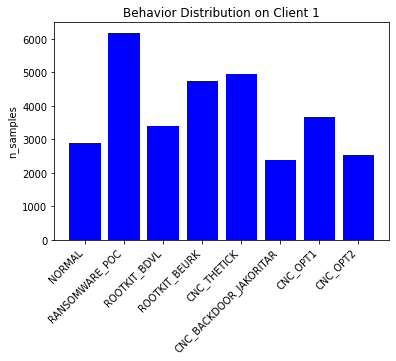

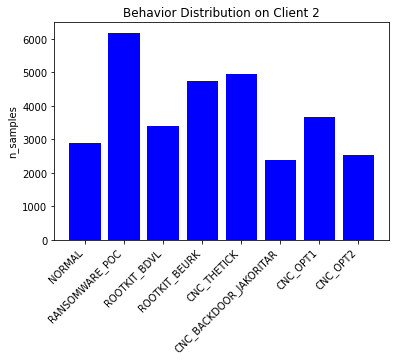

>>> SERVER TRAINING ROUND 1/10 <<<
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETI

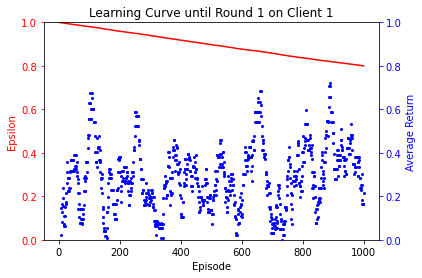

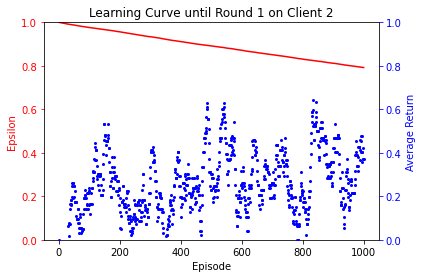

Agent 1
| Behavior           |   Accuracy | Objective                      |
|:-------------------|-----------:|:-------------------------------|
| ransomware_poc     |      98.02 | ransomware_file_extension_hide |
| bdvl               |      98.49 | rootkit_sanitizer              |
| beurk              |      18.69 | rootkit_sanitizer              |
| the_tick           |      81.65 | cnc_ip_shuffle                 |
| backdoor_jakoritar |      81.34 | cnc_ip_shuffle                 |
| data_leak_1        |     100    | cnc_ip_shuffle                 |
| data_leak_2        |     100    | cnc_ip_shuffle                 |
Agent 2
| Behavior           |   Accuracy | Objective                      |
|:-------------------|-----------:|:-------------------------------|
| ransomware_poc     |      96.84 | ransomware_file_extension_hide |
| bdvl               |      98.49 | rootkit_sanitizer              |
| beurk              |      32.44 | rootkit_sanitizer              |
| the_tick        

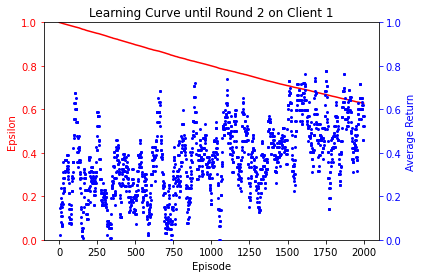

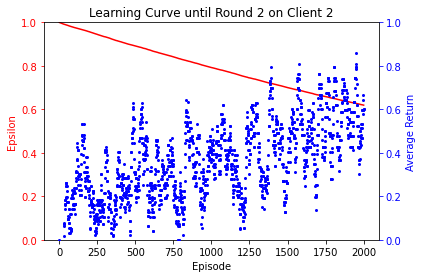

Agent 1
| Behavior           |   Accuracy | Objective                      |
|:-------------------|-----------:|:-------------------------------|
| ransomware_poc     |      97.96 | ransomware_file_extension_hide |
| bdvl               |      98.32 | rootkit_sanitizer              |
| beurk              |      72.21 | rootkit_sanitizer              |
| the_tick           |      33.57 | cnc_ip_shuffle                 |
| backdoor_jakoritar |      29.58 | cnc_ip_shuffle                 |
| data_leak_1        |      99.82 | cnc_ip_shuffle                 |
| data_leak_2        |     100    | cnc_ip_shuffle                 |
Agent 2
| Behavior           |   Accuracy | Objective                      |
|:-------------------|-----------:|:-------------------------------|
| ransomware_poc     |      98.5  | ransomware_file_extension_hide |
| bdvl               |      98.58 | rootkit_sanitizer              |
| beurk              |      36.76 | rootkit_sanitizer              |
| the_tick        

KeyboardInterrupt: 

In [51]:
environment_01 = SensorEnvironment(train_data, interpreter=ae_interpreter, state_samples=SAMPLES)
environment_02 = SensorEnvironment(train_data, interpreter=ae_interpreter, state_samples=SAMPLES)

global_agent = Agent(0, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_01 = Agent(1, input_dims=environment_01.observation_space_size, n_actions=len(environment_01.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_02 = Agent(2, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND, parallelized=False)

client_01 = Client(1, agent_01, environment_01, experiment_path, MIN_REPLAY_SIZE)
client_02 = Client(2, agent_02, environment_02, experiment_path, MIN_REPLAY_SIZE)

server.add_client(client_01)
server.add_client(client_02)

server.run_federation(verbosity=["performance_evaluation", "learning_curve"], evaluation_frequency=1)


# initialize memory replay buffer (randomly)
#SimulationEngine.init_replay_memory(agent=agent, env=env, min_size=MIN_REPLAY_SIZE)

# main training
#episode_returns, eps_history = SimulationEngine.learn_agent_offline(agent=agent, env=env, num_episodes=N_EPISODES,
#                                                                    t_update_freq=TARGET_UPDATE_FREQ)

#end = time()
#print("Total training time: ", end - start)

#num = 0
#agent.save_agent_state(num, experiment_base_dir)

#x = [i + 1 for i in range(N_EPISODES)]
#filename = f"{experiment_base_dir}/mtd_agent_p2_{SAMPLES}_sample.pdf"
#plot_learning(x, episode_returns, eps_history, filename)

# check predictions with dqn from trained and stored agent
#pretrained_agent = get_pretrained_agent(path=f"{experiment_base_dir}/trained_models/agent_{num}.pth",
#                                        input_dims=env.observation_space_size, n_actions=len(env.actions),
#                                        buffer_size=BUFFER_SIZE)

#evaluate_agent(pretrained_agent, test_data=test_data)

# print("evaluate p2 agent on 'real' decision and afterstate data:")
# dtrain, dtest, atrain, atest = DataProvider.get_reduced_dimensions_with_pca_ds_as(dims,
#                                                                                   dir="offline_prototype_2_raw_behaviors/")
# evaluate_agent(agent=pretrained_agent, test_data=dtest)
# evaluate_agent_on_afterstates(agent=pretrained_agent, test_data=atest)


